In [10]:
from tkinter import Tk, filedialog
import os
import unwrap3D.Segmentation.segmentation as segmentation
import scipy.ndimage as ndimage
import skimage.io as skio
import skimage.morphology as skmorph
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Image_Functions.image as image_fn
import numpy as np
import scipy.io as spio 
import unwrap3D.Utility_Functions.file_io as fio
import matplotlib.pyplot as plt
import czifile
import unwrap3D.Visualisation.colors as vol_colors # this is for colormapping any np.array using a color palette 
from matplotlib import cm

'''
from os import path
from GP_modules.file_import import load_czi_file
from GP_modules.file_preprocess import channel_stack_crop
from GP_modules.GP_calc import GP_calculation, GP_calculation_chunked
from GP_modules.image_analysis import object_labelling
'''

'\nfrom os import path\nfrom GP_modules.file_import import load_czi_file\nfrom GP_modules.file_preprocess import channel_stack_crop\nfrom GP_modules.GP_calc import GP_calculation, GP_calculation_chunked\nfrom GP_modules.image_analysis import object_labelling\n'

In [11]:
def select_path():
    """Open a file dialog to select a file."""
    root = Tk()
    root.title("File Selection")
    root.attributes('-alpha', 0.0)

    root.update_idletasks()
    root.deiconify()
    root.focus_force()  # Force focus on the root window

    file_path = filedialog.askopenfilename(parent = root, title="Select an input File", filetypes=[("All", "*.*")])
    root.destroy()  # Close the root window

    return file_path

def separate_path(input_path):
    """Separate the path of the folder and the file name."""
    path = input_path.split("/")
    folder_path = "/".join(path[:-1])
    file_name = os.path.split(input_path)[-1].split('.tif')[0]
    return folder_path, file_name

def binary_seg(img, savefolder0, basefname):
    """Segment the image and save the binary image."""
    
    # returns the binary and the auto determined threshold. 
    img_binary, img_binary_thresh = segmentation.segment_vol_thresh(img, thresh = -1, postprocess=True,post_ksize=3)
    #here thresh -1 because GP min = -1, rest is nan (otsu masking done in GP pipeline)
    
    '''	
    img_binary = ndimage.binary_dilation(img_binary,
                                        iterations=1, 
                                        structure=skmorph.ball(1))
    '''
                                        
    # erode by ball kernel radius = 1 to make a tighter binary for GPMVs, higher leads to less nans in cells
    img_binary = ndimage.binary_erosion(img_binary,iterations=4,structure=skmorph.ball(1))
    
    
    
    
    
    #img_binary = ndimage.binary_fill_holes(img_binary)

    skio.imsave(os.path.join(savefolder0,
                            basefname+'_binary_seg.tif'), 
                np.uint8(255*img_binary))
    
    return img_binary

def a_c_cMCF(voxel_size, img_binary_surf_mesh, H_sdf_vol_normal, img, savefolder0, basefname):
    """"
    We typically use the signed distance function given by the Euclidean distance transform (EDT) 
    as illustrated above to deform the mesh and sample the intensities, as it is fast to compute and 
    memory-efficient. However, when sampling thin, narrow, and long protrusions. The result of 
    the EDT will look 'blocky'. In these cases, it is more optimal to compute the signed 
    distance function given by solving the Poisson equation 
    (see: `unwrap3D.Segmentation.segmentation.poisson_dist_tform_3D`). 
    However, our current implementation uses an exact LU solver which is slow and will likely 
    memory error. We recommend computing the distance transform on the isotropically 
    downsampled binary segmentation (e.g. 1/8th), then resizing the result to the original size. 
    This is valid because the distance transform is smooth.  
    """


    n_samples = 1./ voxel_size # total number of steps

    stepsize = 0.5 # voxels
        
    # flip the mesh vertex coordinates so that it aligns with the volume size 
    img_binary_surf_mesh.vertices = img_binary_surf_mesh.vertices[:,::-1].copy()

    # run the active contour cMCF to get the coordinates at different depths into the cell according to the external image gradient given by the gradient of the signed distance function.
    v_depth = meshtools.parametric_mesh_constant_img_flow(img_binary_surf_mesh, 
                                                        external_img_gradient = H_sdf_vol_normal.transpose(1,2,3,0), 
                                                        niters=int(n_samples/stepsize), 
                                                        deltaL=5e-5, # delta which controls the stiffness of the mesh
                                                        step_size=stepsize, 
                                                        method='implicit', # this specifies the cMCF solver.
                                                        conformalize=True) # ensure we use the cMCF Laplacian
        # get the intensities at the sampled depth coordinates. 
    v_depth_I = image_fn.map_intensity_interp3(v_depth.transpose(0,2,1).reshape(-1,3), 
                                                img.shape, 
                                                I_ref=img)
    v_depth_I = v_depth_I.reshape(-1,v_depth.shape[-1]) # matrix reshaping into a nicer shape. 

    # postprocess to check the total distance from the surface does not exceed the desired and replace any nans.  
    
    dist_v_depth0 = np.linalg.norm(v_depth - v_depth[...,0][...,None], axis=1)
    valid_I = dist_v_depth0<=n_samples
    v_depth_I[valid_I == 0 ] = np.nan # replace with nans

    # compute the mean sampled intensity which will be taken as the surface intensity. 
    surf_intensity_img_raw = np.nanmedian(v_depth_I, axis=1)

    spio.savemat(os.path.join(savefolder0, 
                            basefname+'_surface_curvature_intensity_stats.mat'), 
                {'surf_H': surf_H,
                'surf_intensity' : surf_intensity_img_raw})
    
    return surf_intensity_img_raw
#save stats as csv files ?
#directly use mask gotten in GP calc (object labelling !), check that genus 0 first

def mesh_coloring(img_binary_surf_mesh, 
                    surf_intensity_img_raw, 
                    surf_H, 
                    savefolder0, 
                    basefname):

    """
    coloring of mesh based on nanfilter
    
    mask_valid = ~np.isnan(surf_intensity_img_raw)
    mask_invalid = np.isnan(surf_intensity_img_raw)
    filter_array = np.copy(surf_intensity_img_raw)
    filter_array[mask_valid] = 1
    filter_array[mask_invalid] = -1
    I_min_filter = -1.3
    I_max_filter = 1.3
    #print number of valid, invalid points and of total points
    print('Number of total points: ', surf_intensity_img_raw.size)
    print('Number of valid points: ', np.sum(mask_valid))
    print('Number of invalid points: ', np.sum(mask_invalid))
    """

    """
    #coloring of mesh based on intensity and curvature for GPMVs
    I_min_filter = -1.3
    I_max_filter = 1

    mask_A = (surf_intensity_img_raw >= 0.025) & \
       (surf_H >= 0.007) & (surf_H <= 0.05)

    mask_B = (surf_intensity_img_raw < 0.025) & \
        (surf_H >= 0.007) & (surf_H <= 0.05)

    mask_C = (surf_intensity_img_raw >= 0.025) & \
        (surf_H > 0.05) 

    mask_D = (surf_intensity_img_raw < 0.025) & \
        (surf_H > 0.05)

    mask_E = (surf_H < 0.007)

    filter_array = np.zeros_like(surf_H)
    filter_array[mask_A] = 1 
    filter_array[mask_B] = 0.5 
    filter_array[mask_C] = 0 
    filter_array[mask_D] = -0.5 
    filter_array[mask_E] = -1
    """
    """ 
    coloring of GMPV phases
    I_min_filter = -1
    I_max_filter = 1

    mask_ordered = (surf_intensity_img_raw > 0.1)

    filter_array = np.zeros_like(surf_H)
    filter_array[mask_ordered] = 1
    """

    
    #coloring of mesh based on intensity and curvature for cell
    I_min_filter = -1.3
    I_max_filter = 1

    mask_A = (surf_H>=-0.005) & (surf_H<=0.005) 

    mask_B = (surf_H < -0.005) 

    mask_C = (surf_H > 0.005) & (surf_H <= 0.04)

    mask_D = (surf_H > 0.04) & (surf_H <= 0.15)
    
    mask_E = (surf_H > 0.15)

    mask_invalid = np.isnan(surf_intensity_img_raw)



    filter_array = np.zeros_like(surf_H)
    filter_array[mask_A] = 1 
    filter_array[mask_B] = 0.5 
    filter_array[mask_C] = 0
    filter_array[mask_D] = -0.5
    filter_array[mask_E] = -1
    filter_array[mask_invalid] = 0.2

    """
    
    I_min_filter = -1
    I_max_filter = 1

    mask_ordered = (surf_intensity_img_raw > 0.1)

    filter_array = np.zeros_like(surf_H)
    filter_array[mask_ordered] = 1
    """ 
    

    filter_raw_colors = vol_colors.get_colors(filter_array, 
                                            colormap=cm.hsv,   
                                            vmin=I_min_filter, 
                                            vmax=I_max_filter)
    
    filter_mesh_colors = meshtools.create_mesh(vertices=img_binary_surf_mesh.vertices[:,::-1],
                                                    faces=img_binary_surf_mesh.faces, 
                                                    vertex_colors=np.uint8(255*filter_raw_colors[...,:3]))

    tmp = filter_mesh_colors.export(os.path.join(savefolder0, 
                                                    'filtered_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.

    """	
    Coloring of the mesh after intensity values
    """

    surf_intensity_img_raw_visu = np.copy(surf_intensity_img_raw)
    #remove nans from the intensity image for visualization
    surf_intensity_img_raw_visu[np.isnan(surf_intensity_img_raw)] = 0
    I_min_intensity = np.percentile(surf_intensity_img_raw_visu,1)
    I_max_intensity = np.percentile(surf_intensity_img_raw_visu,99)
    surf_intensity_img_raw_colors = vol_colors.get_colors(surf_intensity_img_raw_visu, 
                                                        colormap=cm.RdYlBu_r,   
                                                        vmin=I_min_intensity, 
                                                        vmax=I_max_intensity)
    # create a new surface mesh, now with the intensity molecular signal colors. 
    img_binary_surf_mesh_colors = meshtools.create_mesh(vertices=img_binary_surf_mesh.vertices[:,::-1],
                                                    faces=img_binary_surf_mesh.faces, 
                                                    vertex_colors=np.uint8(255*surf_intensity_img_raw_colors[...,:3])) 
    
    # save the mesh with the colors.
    tmp = img_binary_surf_mesh_colors.export(os.path.join(savefolder0, 
                                                    'intensity_binary_mesh_'+basefname+'.obj'))
    
    """	
    Coloring of the mesh after curvature values
    """
    voxel_size = 0.104 #um
    surf_H_colors = vol_colors.get_colors(surf_H/voxel_size, # 0.104 is the voxel resolution -> this converts to um^-1 
                                        colormap=cm.Spectral_r, 
                                        vmin=-1., 
                                        vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

    # set the vertex colors to the computed mean curvature color
    img_binary_surf_mesh_colors = meshtools.create_mesh(vertices=img_binary_surf_mesh.vertices[:,::-1],
                                                    faces=img_binary_surf_mesh.faces, 
                                                    vertex_colors=np.uint8(255*surf_H_colors[...,:3])) 
    tmp = img_binary_surf_mesh_colors.export(os.path.join(savefolder0, 'curvature_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.

voxel_size = 0.104 #um
imgfile = select_path()
imgfolder, basefname = separate_path(imgfile)
savefolder0 = os.path.join(imgfolder, 'Results', basefname, "curvature_analysis")
fio.mkdir(savefolder0)


img = skio.imread(imgfile).squeeze()

'''
#read with czi reader
with czifile.CziFile(imgfile) as czi:
    img = czi.asarray().squeeze()
'''
    
img_binary = binary_seg(img, savefolder0, basefname)

img_binary_surf_mesh = meshtools.marching_cubes_mesh_binary(img_binary.transpose(2,1,0), # The transpose is to be consistent with ImageJ rendering and Matlab convention  
                                                                presmooth=1., # applies a presmooth
                                                                contourlevel=.5,
                                                                remesh=True,
                                                                remesh_method='CGAL', # 'pyacvd' = method 1, 'CGAL' = method 2
                                                                remesh_samples=.5, # remeshing with a target #vertices. 0.5 = 50% of original vertex number
                                                                predecimate=False, # this applies quadric mesh simplication to remove very small edges before remeshing. This must be True if using method 1, 'pyacvd'
                                                                min_mesh_size=10000, # enforce at least this number of vertices.
                                                                upsamplemethod='inplane') # upsample the mesh if after the simplification and remeshing < min_mesh_size  

surf_H, (H_binary, H_sdf_vol_normal, H_sdf_vol) = meshtools.compute_mean_curvature_from_binary(img_binary_surf_mesh, 
                                                                                    img_binary.transpose(2,1,0), 
                                                                                    smooth_gradient=3, # adjusts smoothing, plays similar role to neighborhood radius in mesh method
                                                                                    eps=1e-12,
                                                                                    invert_H=False, # set True if you want positive values to correspond to positive curvature on the surface like blebs and binary is not transposed, otherwise set False. 
                                                                                    return_H_img=True) # set return_H_img to be True, if 

surf_intensity_img_raw = a_c_cMCF(voxel_size, img_binary_surf_mesh, H_sdf_vol_normal, img, savefolder0, basefname)

mesh_coloring(img_binary_surf_mesh,
                surf_intensity_img_raw, 
                surf_H, 
                savefolder0, 
                basefname)



100%|██████████| 19/19 [00:03<00:00,  5.05it/s]
C:\Users\champ\AppData\Local\Temp\ipykernel_10652\2116269233.py:94: RuntimeWarning: All-NaN slice encountered
  surf_intensity_img_raw = np.nanmedian(v_depth_I, axis=1)


In [12]:
curvature_data = surf_H.flatten()
intensity_data = surf_intensity_img_raw.flatten()

valid_indices = ~np.isnan(curvature_data) & ~np.isnan(intensity_data) 
curvature_data = curvature_data[valid_indices]
intensity_data = intensity_data[valid_indices]

Text(0.5, 1.0, 'Scatter Plot of Curvature vs. Intensity with Color Mapping')

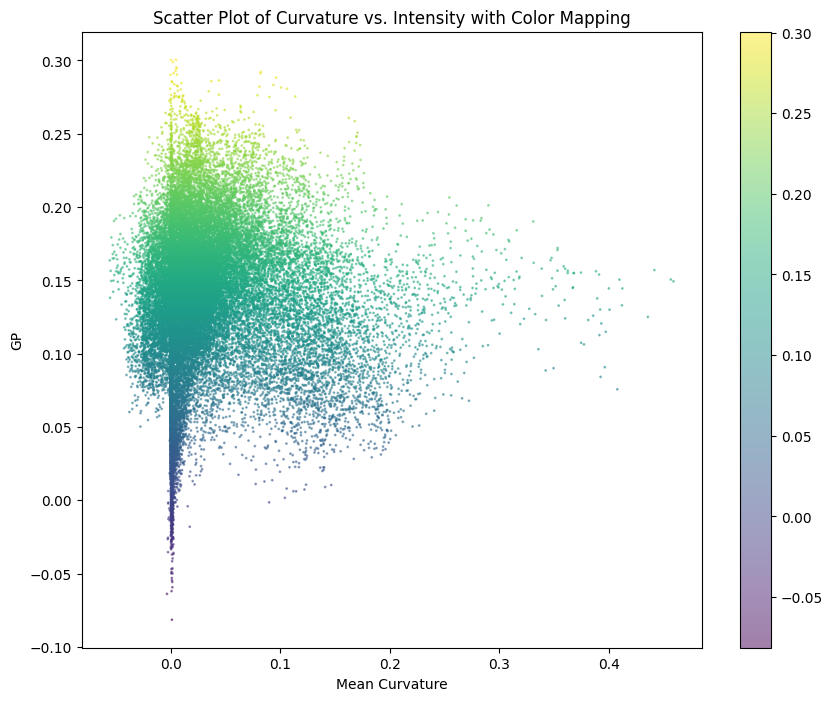

In [13]:
#scatter plot of curvature vs intensity with matplot colomap 
plt.figure(figsize=(10, 8))
plt.scatter(curvature_data, intensity_data, c=intensity_data, cmap='viridis', alpha=0.5, s=1)  # Adjust size and transparency as needed
plt.colorbar()
plt.xlabel('Mean Curvature')
plt.ylabel('GP')
plt.title('Scatter Plot of Curvature vs. Intensity with Color Mapping')

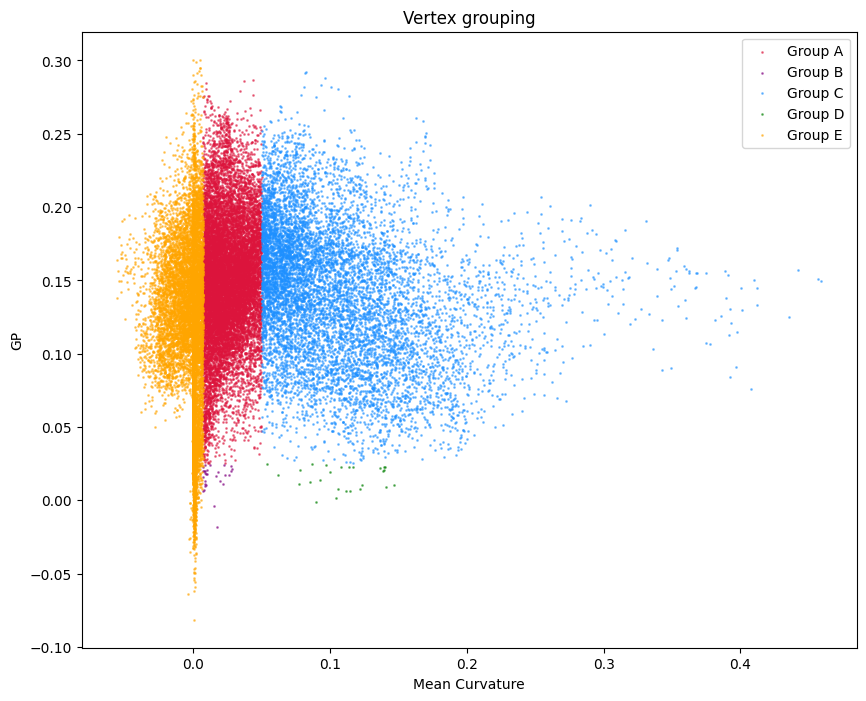

In [14]:
import matplotlib.pyplot as plt

#GPMV data group coloring
# Define mask for the condition
mask_A = (intensity_data >= 0.025) & \
       (curvature_data >= 0.007) & (curvature_data <= 0.05)

mask_B = (intensity_data < 0.025) & \
       (curvature_data >= 0.007) & (curvature_data <= 0.05)

mask_C = (intensity_data >= 0.025) & \
       (curvature_data > 0.05) 

mask_D = (intensity_data < 0.025) & \
       (curvature_data > 0.05)

mask_E = (curvature_data < 0.007)

plt.figure(figsize=(10, 8))

"""
mask_none = ~(mask_A | mask_B | mask_C | mask_D | mask_E)  # Mask for points outside the region


# Plot points outside the region with colormap
scatter1 = plt.scatter(curvature_data[mask_none], intensity_data[mask_none],
                     c=intensity_data[mask_none], cmap='viridis', alpha=0.5, s=1)
"""
                     
# Plot points inside the region with a specific color (e.g., red)
scatterA = plt.scatter(curvature_data[mask_A], intensity_data[mask_A],
                     color='crimson', alpha=0.5, s=1, label='Group A')

scatterB = plt.scatter(curvature_data[mask_B], intensity_data[mask_B],
                     color='purple', alpha=0.5, s=1, label='Group B')

scatterC = plt.scatter(curvature_data[mask_C], intensity_data[mask_C],
                     color='dodgerblue', alpha=0.5, s=1, label='Group C')

scatterD = plt.scatter(curvature_data[mask_D], intensity_data[mask_D],
                     color='green', alpha=0.5, s=1, label='Group D')

scatterE = plt.scatter(curvature_data[mask_E], intensity_data[mask_E],
                     color='orange', alpha=0.5, s=1, label='Group E')

#plt.colorbar(scatter1, label='GP (Intensity)')
plt.xlabel('Mean Curvature')
plt.ylabel('GP')
plt.title('Vertex grouping')
plt.legend()
plt.show()


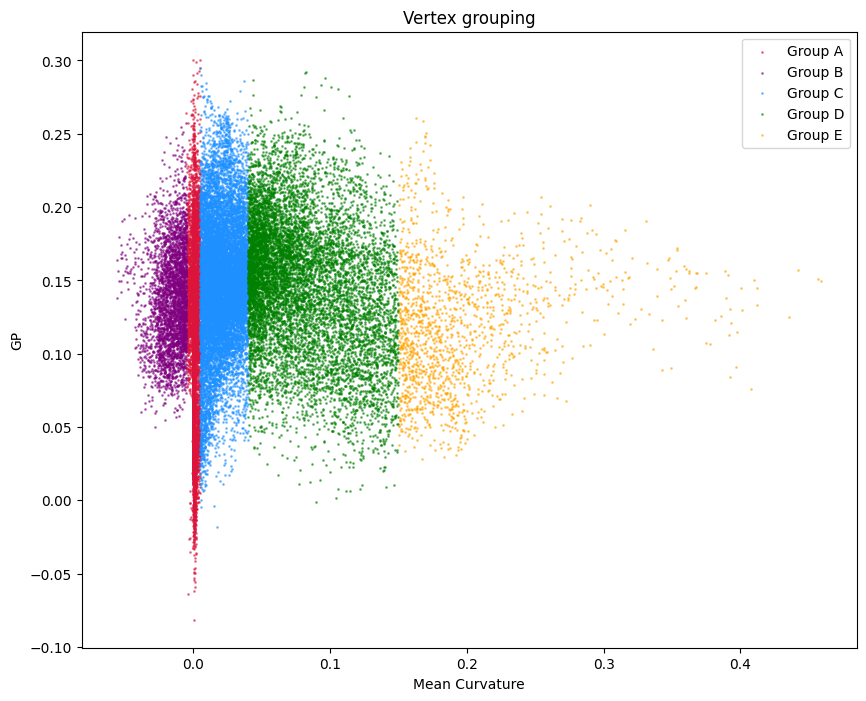

In [ ]:
#cell data group coloring

mask_A = (curvature_data>=-0.005) & (curvature_data<=0.005) 

mask_B = (curvature_data< -0.005) 

mask_C = (curvature_data > 0.005) & (curvature_data <= 0.04)

mask_D = (curvature_data > 0.04) & (curvature_data <= 0.15)

mask_E = curvature_data > 0.15

plt.figure(figsize=(10, 8))


mask_none = ~(mask_A | mask_B | mask_C| mask_D)  # Mask for points outside the region


# Plot points outside the region with colormap

                     
# Plot points inside the region with a specific color (e.g., red)
scatterA = plt.scatter(curvature_data[mask_A], intensity_data[mask_A],
                     color='crimson', alpha=0.5, s=1, label='Group A')

scatterB = plt.scatter(curvature_data[mask_B], intensity_data[mask_B],
                     color='purple', alpha=0.5, s=1, label='Group B')

scatterC = plt.scatter(curvature_data[mask_C], intensity_data[mask_C],
                     color='dodgerblue', alpha=0.5, s=1, label='Group C')

scatterD = plt.scatter(curvature_data[mask_D], intensity_data[mask_D],
                     color='green', alpha=0.5, s=1, label='Group D')

scatterE = plt.scatter(curvature_data[mask_E], intensity_data[mask_E],
                     color='orange', alpha=0.5, s=1, label='Group E')


#plt.colorbar(scatter1, label='GP (Intensity)')
plt.xlabel('Mean Curvature')
plt.ylabel('GP')
plt.title('Vertex grouping')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

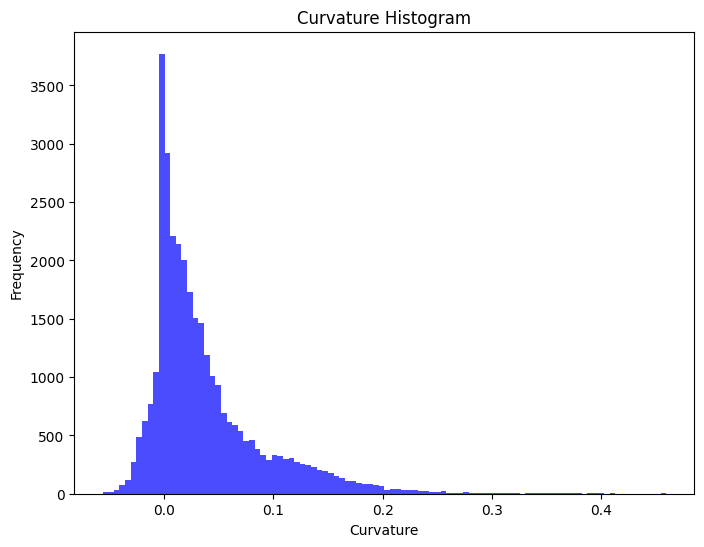

In [24]:
#plot hisrtogram of curvature
plt.figure(figsize=(8, 6))
plt.hist(curvature_data.squeeze(), bins=100, color='blue', alpha=0.7)
plt.title('Curvature Histogram')
plt.xlabel('Curvature')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

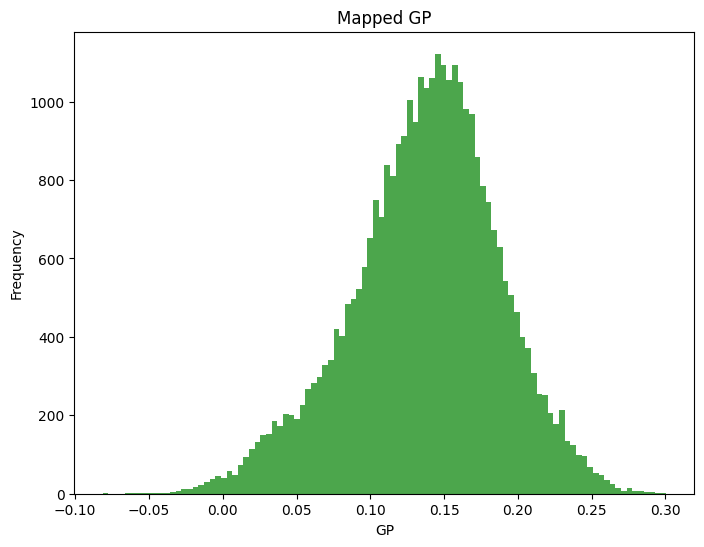

In [17]:
#plot intensities histogram
plt.figure(figsize=(8, 6))
plt.hist(intensity_data.squeeze(), bins=100, color='green', alpha=0.7)
plt.title('Mapped GP')
plt.xlabel('GP')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

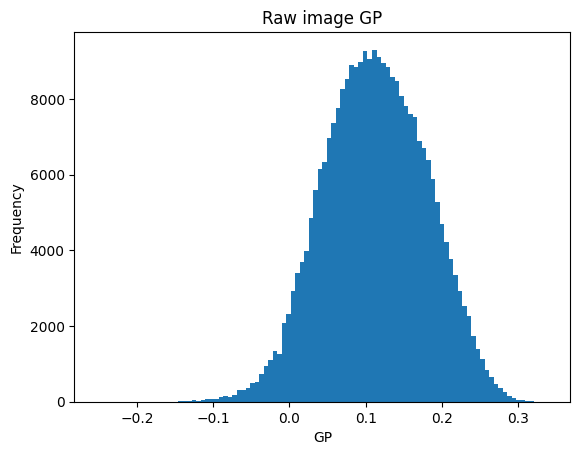

In [18]:
#do a histogram of the raw img data
plt.hist(img.flatten(), bins=100)
plt.title('Raw image GP')
plt.xlabel('GP')
plt.ylabel('Frequency')
